In [85]:
import numpy as np 
import pandas as pd
import scipy

TS = 48 # Time steps
UID = 5 # Householder ID
MBC = 0. # Max capacitiy of Battery

df = pd.read_csv('AusGrid_preprocess.csv', header=[0,1], index_col=0)
df = df.set_index(pd.to_datetime(df.index))
df.columns = df.columns.set_levels(df.columns.levels[0].astype('int64'), level=0)
df = df/2000.
df_date = df.index
df.head()

customers = sorted(df.columns.levels[0])
data_test = df[UID][['GG', 'GC']]
load = data_test['GC'].to_numpy()
pvgn = data_test['GG'].to_numpy()

In [86]:
def batt_model(u, x, pv, ld):
    x_next = np.zeros(2)
    # print('batt_model', u, x, pv, ld)
    x_next[0] = ld - pv + u[0]
    x_next[1] = x[1] + u[0] 

    return x_next

In [87]:
def cost(u, x, pv, ld):
    cost_val = 0.0
    x =  batt_model(u, x, pv, ld)
    cost_val += x[0]**2
    return cost_val

In [88]:
LDT = len(load)
BCMIN = 0.10
BCMAX = 0.95
x0 = np.array([0, MBC*BCMIN])
u0 = 0
u = []
x = []
for i in range(LDT):
    bnds = ((MBC*BCMIN-x0[1], MBC*BCMAX - x0[1]),)
    res = scipy.optimize.minimize(cost, u0, bounds=bnds, args=(x0, pvgn[i], load[i]))
    u0 = res.x
    x0 = batt_model(u0, x0, pvgn[i], load[i])
    u.append(u0)
    x.append(x0)
x = np.array(x)
print(res.x)
print(res.fun)

[0.]
0.998001


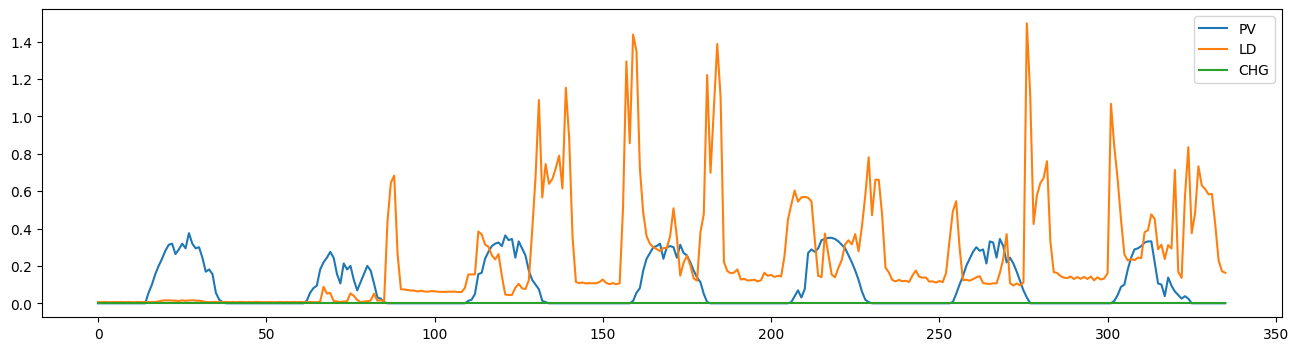

In [89]:
import matplotlib.pyplot as plt 

start = TS*250
end = start+TS*7
fig = plt.figure(figsize=(16, 4))
# plt.plot(x[start:end, 0], label='GRD')
# plt.plot(x[start:end, 1], label='SOC')
plt.plot(pvgn[start:end], label='PV')
plt.plot(load[start:end], label='LD')
plt.plot(u[start:end], label='CHG')
plt.legend()

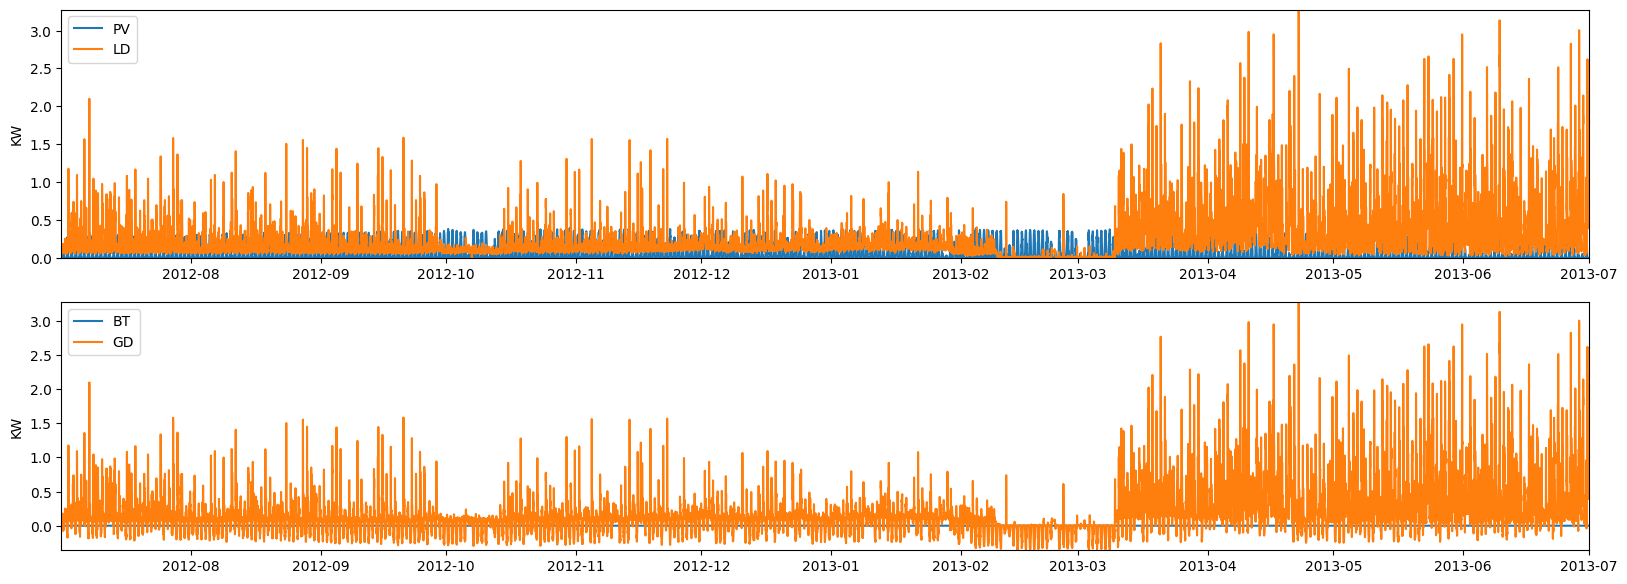

In [90]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,6))
plt.rcParams["font.size"] = "10"
fig.tight_layout()

axes[0].plot(df_date.values, pvgn, label='PV', color='#1f77b4')
axes[0].plot(df_date.values, load, label='LD', color='#ff7f0e')
axes[0].legend(loc='upper left')
axes[0].set_ylabel('KW')
axes[0].grid(False)
axes[0].margins(0,0)

axes[1].plot(df_date.values, x[:, 1], label='BT', color='#1f77b4')
axes[1].plot(df_date.values, x[:, 0], label='GD', color='#ff7f0e')
axes[1].legend(loc='upper left')
axes[1].set_ylabel('KW')
axes[1].grid(False)
axes[1].margins(0,0)

In [91]:
Egen = pvgn.sum()
print(Egen, 'KW')
Eload = load.sum()
print(Eload, 'KW')
GDimport = x[:, 0][x[:, 0]>0].sum()
print(GDimport)
GDexport = x[:, 0][x[:, 0]<0].sum()
print(GDexport)

SC = (Egen + GDexport)/Egen
SS = (Egen + GDexport)/Eload
print('SC :', SC)
print('SS :', SS)

1262.292 KW
3995.3110000000006 KW
3225.821
-492.802
SC : 0.6095974623938042
SS : 0.19259827332590623
